<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/NN-online/blob/main/wgan_gp_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.4/586.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 28.1 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.6.4
    Uninstalling websocket-client-1.6.4:
      Successfully uninstalled websocket-client-1.6.4
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [ ]:
import comet_ml
from comet_ml.integration.pytorch import load_model

In [ ]:
!rm -rf /root/.comet.config

In [ ]:
comet_ml.init()

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [ ]:
import torch
import torch.nn as nn

# The networks are taken from
# https://arxiv.org/abs/1511.06434
class TBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size,stride,pad,norm_type):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_ch,out_ch,kernel_size,stride, pad,bias=False),
            norm_layer(out_ch,norm_type),
            nn.ReLU()
        )
    def forward(self,x):
        return self.net(x)
class CBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size,stride,pad,norm_type: str = "batch"):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,out_ch,kernel_size,stride, pad, bias=False),
            norm_layer(out_ch,norm_type),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.net(x)

class Generator(nn.Module):
    #Outputs 64x64 pixel images

    def __init__(
        self,img_size=64,
        out_ch=3,zdim=100,norm_type="BatchNorm2d",final_activation=None
    ):
        super().__init__()
        # self.nf_g = nf_g
        # self.z_dim = z_dim
        # self.out_ch = out_ch
        nf_g=2*img_size
        self.final_activation=None if final_activation is None else getattr(torch,final_activation)

        self.net = nn.Sequential(
            # * Layer 1: 1x1
            TBlock(zdim,8*nf_g, 4,1, 0,norm_type),
            # * Layer 2: 4x4
            TBlock(8*nf_g,4*nf_g,4,2,1,norm_type),
            # * Layer 3: 8x8
            TBlock(4*nf_g,2*nf_g,4,2,1,norm_type),
            # * Layer 4: 16x16
            TBlock(2*nf_g,nf_g,4,2,1,norm_type),
            # * Layer 5: 32x32
            nn.ConvTranspose2d(nf_g, out_ch, 4, 2, 1, bias=False),
            # * Output: 64x64
        )

    def forward(self, x):
        x = self.net(x)
        return x if self.final_activation is None else self.final_activation(x)

        #return torch.tanh(x)


class Discriminator(nn.Module):
    def __init__(self, img_size=64,in_ch=3,norm_type="BatchNorm2d",final_activation=None):
        super().__init__()
        nf_d=img_size
        self.final_activation=None if final_activation is None else getattr(torch,final_activation)
        self.net = nn.Sequential(
            # * 64x64
            nn.Conv2d(in_ch, nf_d, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            # * 32x32
            CBlock(nf_d,2*nf_d,4,2,1,norm_type),
            # * 16x16
            CBlock(2*nf_d,4*nf_d,4,2,1,norm_type),
            # * 8x8
            CBlock(4*nf_d,8*nf_d,4,2,1,norm_type),
            # * 4x4
            nn.Conv2d(8*nf_d, 1, 4, 1, 0, bias=False),
        )


    def forward(self, x):
          x = self.net(x)
          return x if self.final_activation is None else self.final_activation(x)

class norm_layer(nn.Module):
    def __init__(self, num_channels,norm_type: str = None):
        super().__init__()
        if norm_type == "BatchNorm2d":
            self.norm = nn.BatchNorm2d(num_channels)
        elif norm_type == "GroupNorm":
            self.norm = nn.GroupNorm(num_channels, num_channels)
        elif norm_type is None or norm_type == "None":
            self.norm=None
        else:
            raise ValueError(f"Unknown normalization type: {norm_type}")

    def forward(self, x):
        return x if self.norm is None else self.norm(x)


In [ ]:
generator=Generator(64,3,128,norm_type="GroupNorm",final_activation="tanh")
discriminator=Discriminator(64,3,norm_type="GroupNorm",final_activation=None)
checkpoint=load_model("registry://wgan/WGAN-GP:1.0.0")
generator.load_state_dict(checkpoint["g_state_dict"])
discriminator.load_state_dict(checkpoint["d_state_dict"])

COMET INFO: Downloading registry model 'WGAN-GP', version '1.0.0', stage None from workspace 'wgan'...
COMET INFO: Unzipping model to '/tmp/tmpeb9anbym' ...
COMET INFO: done!
COMET WARNING: Torch versions mismatch during model loading. Model was uploaded with torch==2.1.0. Current version is 2.1.0+cu118


<All keys matched successfully>

In [ ]:
from torchvision.utils import make_grid

In [ ]:
device='cuda'
generator=generator.to(device)

In [ ]:
def random_sample(batch_size, z_dim, device):
        # input to the generator
        # z_dim channels, 1x1 pixels
        return torch.randn(batch_size,z_dim, 1, 1).to(device)

In [ ]:
def generate_images(nsamples):
        with torch.no_grad():
            noise = random_sample(256, 128, device)[:nsamples]
            fake_images = generator(noise)
        return fake_images
fake_images=generate_images(32)
grid = make_grid(fake_images, nrow=8, normalize=True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

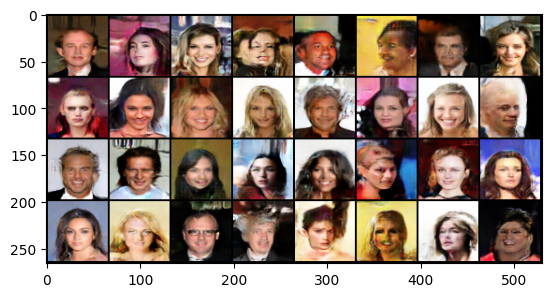

In [ ]:
def recover_image(img):
        # PIL expects the image to be of shape (H,W,C)
        # in PyTorch it's (C,H,W)

        img=img.cpu().numpy().transpose(1, 2,0)*255
        return Image.fromarray(img.astype(np.uint8))
grid=recover_image(grid)
plt.imshow(grid)